In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class Token():

    def balanceOf(self, accountName):
        return self.__balances.get(accountName)
  
    def setBalance(self, accountName, amount):
        self.__balances.update({accountName : amount})

class RebasingToken():
    MAX_UINT256 = 2**256


R_RATE = 0.001

class RebaseEvent():

    def __init__(self, rebase_rate = R_RATE):
        self.__rebase_rate = rebase_rate
        self.__token = np.array([0,0])
        self.__cToken = np.array([0,0])
        self.__dToken = np.array([0,0])
        self.__tToken = 0
       
    def get_cToken(self):
        return self.__cToken
    
    def get_tToken(self):
        return self.__tToken    
    
    def get_rRate(self):
        return self.__rebase_rate    
    
    def update_cToken(self, tokenArr):
        self.__cToken = tokenArr  
 
    def deposit(self, depositArr):
        for k in range(2):
            self.__token[k] = depositArr[k] + self.__token[k]             
        return self.__token; 

    def update_rebase(self, prevArr):
        for k in range(2):
            prevArr[k] = R_RATE*prevArr[k] + prevArr[k]             
        return prevArr;   
    
    def liquidity_pair(self, tokenArr):
        return np.sqrt(tokenArr[0]*tokenArr[1])    
        
    def update_tToken(self, token):
        self.__tToken = token    
              
    def trade(self, token, rate):
        return token*rate;        
                

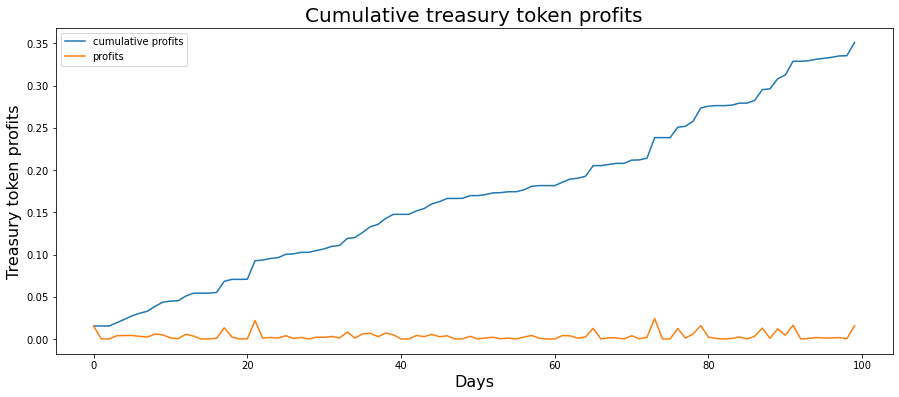

In [5]:
rebase = RebaseEvent()

tToken = 0
token1 = 0
token2 = 0

tTokenProfits = np.array([])

dToken = 0

cToken1 = 0
cToken2 = 0
cToken = 0

exch_rate = 1

N = 100

for k in range(N):
    
    shape = np.random.poisson(2, 1)
    scale = np.random.poisson(2, 1)
    dToken1 = np.random.gamma(shape, scale, 1)
    dToken2 = np.random.gamma(shape, scale, 1)

    dToken = rebase.liquidity_pair(np.array([dToken1,dToken2]))

    tokenArr = rebase.deposit(np.array([dToken1,dToken2]))

    dTokenArr = rebase.update_rebase(np.array([dToken1,dToken2]))

    rebase.update_cToken(tokenArr)

    cTokenArr = rebase.get_cToken()
    cToken = rebase.liquidity_pair(cTokenArr)

    rebase.update_tToken(cToken)

    tToken = rebase.get_tToken()

    pToken = rebase.liquidity_pair(dTokenArr) -  dToken

    pTToken = rebase.trade(pToken, exch_rate)
    tToken = tToken + pTToken

    tTokenProfits = np.hstack((tTokenProfits,pTToken))

cTTokenProfits = np.cumsum(tTokenProfits) 
tSamp = np.array(range(N))

fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(tSamp, cTTokenProfits, label='cumulative profits') 
plt.plot(tSamp, tTokenProfits, label='profits') 
plt.title("Cumulative treasury token profits", fontsize=20)
plt.ylabel("Treasury token profits", fontsize=16)
plt.xlabel('Days', fontsize=16)
plt.legend()

token = Token()

